# Import libraries, create document class to hold info

In [27]:
#  /Data/celebs-usa/female contains 381 texts by females
#  /Data/celebs-usa/male contains 912 texts by males
#  /Data/celebs-other-json contains text by

# Identify birth year as that is a constant, these tweets are from 2011-2018, age range constantly changes but birth year stays constant
# using birth year, predict age 10-15, 15-20, 20-25, 25-30, 30-35, 35-40, 45-55,55+  
#{'25-34', '35-44', '45-54', '55-64', '65+'}

from os import listdir, makedirs
from os.path import isfile, join, splitext, split
import json
from collections import Counter
import ftfy
import re
import nltk
import copy
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import ndjson
import pickle
import os
import jsonlines
from sklearn.base import BaseEstimator, TransformerMixin

        
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

        
class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens
    
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)
            
def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) 
    #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

def custom_tokenise(text):
    return tokenise_re.findall(text.lower())

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

# Reading in Celebrity Data, converting to Document Class and saving to pickle file

In [28]:
'''
This gets the celebrity data and adds the correct gender and ages 
to each json object with text
'''
def getCelebData():
    path = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/feeds.ndjson'
    path2 = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/labels.ndjson'

    # Read in the twitter text
    data = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            data.append(obj)
            if len(data) >19999:
                break;
    # Here the correct labels are identified and paried           
    labels = []
    with jsonlines.open(path2) as reader:
        for obj in reader:
            if obj['gender']!='nonbinary':
                for d in data:
                    if d['id'] == obj['id']:
                        d['gender'] = obj['gender']
                        d['birthyear'] = obj['birthyear']
    return data

'''
This function returns the 5 year group a year of birth resides in, e.g. 1995 is between 1995-1999 (inclusive 5 year period)
'''
def getYearRange(yearOfBirth):
    YearGroupGap = 5
    for minYear in range(1900,2015,YearGroupGap):
        maxYear = minYear+YearGroupGap
        #print('min: ',minYear,'max: ',maxYear)
        if (yearOfBirth >= minYear) and (yearOfBirth < maxYear):
            return( str(minYear)+'-'+str(maxYear-1) )
    raise Exception('year of Birth passed in - ' + str(yearOfBirth)+' is not in range of min and max years' ) 
    

'''
This helper function uses the Document class to return a doc
class for each user with the correct gender, age and tweets
'''
def getDocument(data):
    try:
        gender    = data['gender']
        birthyear = data['birthyear']
        if data['birthyear'] != 'unknown':
            birthYearRange = getYearRange(data['birthyear'])

        doc = Document({'gender': gender, 'birthyear':birthyear, 'birthyearrange':birthYearRange}) #include metadata
        for tweet in data['text']:
            doc.extract_features_from_text(tweet)
        return doc
    except:
        print("An exception occurred")

'''
Check if the pickle file exists, if not then create it, else read in
'''
corpus = []
if os.path.exists("/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile"):
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'rb') as fp:
        corpus = pickle.load(fp)
    print('CELEB FILE EXISTS')
else:
    print('CELEB FILE DOES NOT EXISTS, CREATING')
    # Call the function to get the twitter data
    corpus = getCelebData()
    #For each json object, convert it to a document object
    for i in range(len(corpus)):
        print('Doing Obj Number: ',i)
        corpus[i] = getDocument(corpus[i])
    
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)
    print('CELEB FILE CREATED')

CELEB FILE EXISTS


# Exploratory Data Analysis

/home/jay/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


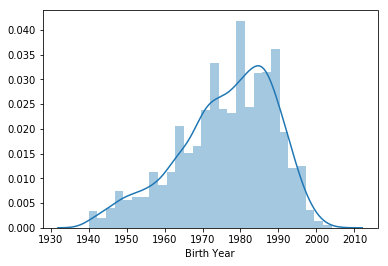

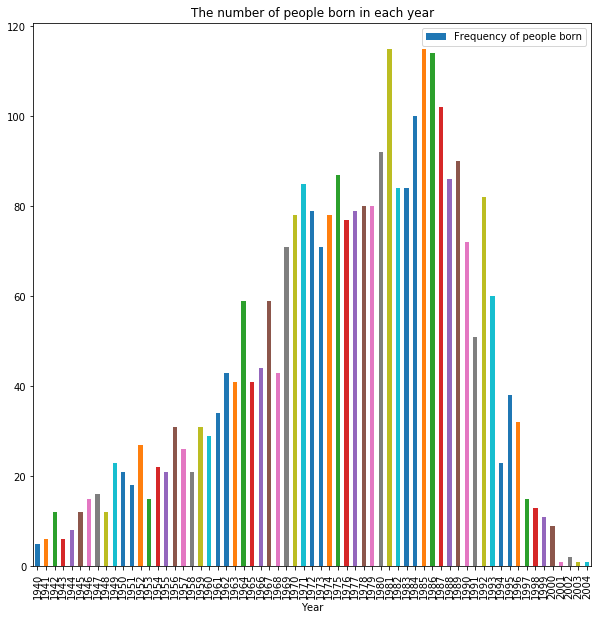

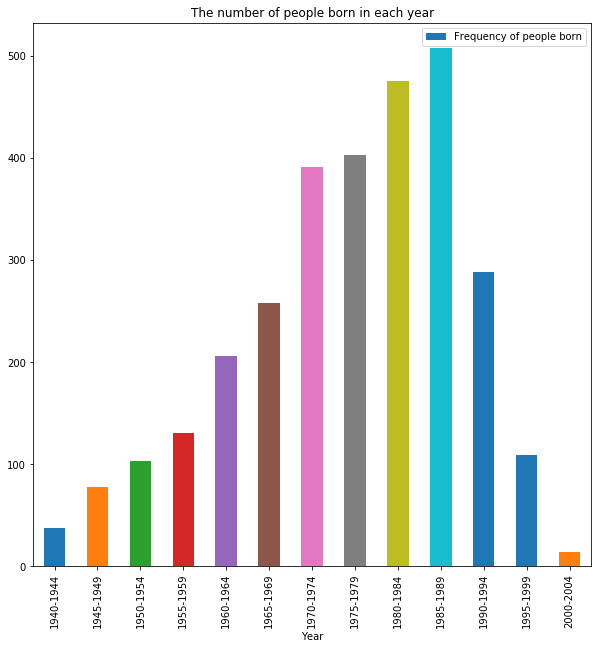

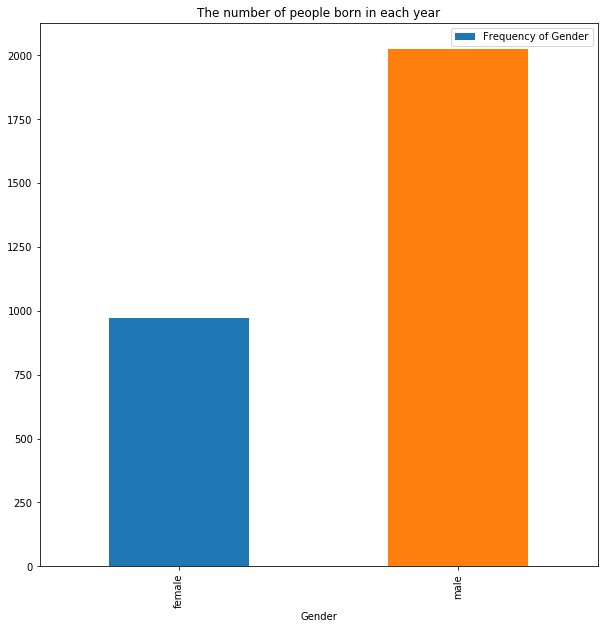

In [29]:
corpus = [d for d in corpus if d.meta['gender'] != 'nonbinary']
#Get all the birth years and plot a histogram
birth_year_y = [d.meta['birthyear'] for d in corpus]
x = pd.Series(birth_year_y, name="Birth Year")
sns.distplot(x)

#Get a count of of the birth years and plot a bar chart
df = pd.DataFrame.from_dict(Counter(birth_year_y), orient='index').reset_index()
df.columns = ['Year','Frequency of people born']
df = df.sort_values(by=['Year'])
df.plot.bar(x='Year', y='Frequency of people born', rot=90,figsize=(10,10), title='The number of people born in each year')
df

#Get all the birth years and plot a histogram
birth_year_y = [d.meta['birthyearrange'] for d in corpus]
df = pd.DataFrame.from_dict(Counter(birth_year_y), orient='index').reset_index()
df.columns = ['Year','Frequency of people born']
df = df.sort_values(by=['Year'])
df.plot.bar(x='Year', y='Frequency of people born', rot=90,figsize=(10,10), title='The number of people born in each year')

#Get all the genders and plot a bar chart
gender_y = [d.meta['gender'] for d in corpus]
df = pd.DataFrame.from_dict(Counter(gender_y), orient='index').reset_index()
df.columns = ['Gender','Frequency of Gender']
df.plot.bar(x='Gender', y='Frequency of Gender', rot=90,figsize=(10,10), title='The number of people born in each year')


# Get Train and Test Split

In [30]:
from sklearn.model_selection import train_test_split

##################THIS NEEDS TO BE DEALT WITh
#Undersample men 
femaleCorpus = [d for d in corpus if d.meta['gender'] == 'female']
maleCorpus   = [d for d in corpus if d.meta['gender'] == 'male']
genderCorpus = maleCorpus[:1000] + femaleCorpus
##################THIS NEEDS TO BE DEALT WITh
#Undersample men    

#Getting gender Train and Test
gender_y = [d.meta['gender'] for d in genderCorpus]
gender_X = genderCorpus
Gender_X_train, Gender_X_test, Gender_y_train, Gender_y_test = train_test_split(gender_X,gender_y, test_size=0.3, random_state = 0)
genderCorpus = [d for d in corpus if d.meta['gender'] != 'nonbinary']

#Getting Birth_year_range Train and Test
birth_year_y = [d.meta['birthyearrange'] for d in corpus]
birth_year_y = [d.meta['birthyear'] for d in corpus]
birth_year_X = corpus
Birth_X_train, Birth_X_test, Birth_y_train, Birth_y_test = train_test_split(birth_year_X,birth_year_y, test_size=0.3, random_state = 0)
genderCorpus = [d for d in corpus if d.meta['gender'] != 'nonbinary']


GenderCount = Counter(gender_y)
BirthYearCount = Counter(birth_year_y)
print(GenderCount)
print('---------------')
print(BirthYearCount)

Counter({'male': 1000, 'female': 973})
---------------
Counter({1985: 115, 1981: 115, 1986: 114, 1987: 102, 1984: 100, 1980: 92, 1989: 90, 1975: 87, 1988: 86, 1971: 85, 1982: 84, 1983: 84, 1992: 82, 1978: 80, 1979: 80, 1977: 79, 1972: 79, 1974: 78, 1970: 78, 1976: 77, 1990: 72, 1969: 71, 1973: 71, 1993: 60, 1967: 59, 1964: 59, 1991: 51, 1966: 44, 1968: 43, 1962: 43, 1965: 41, 1963: 41, 1995: 38, 1961: 34, 1996: 32, 1959: 31, 1956: 31, 1960: 29, 1952: 27, 1957: 26, 1994: 23, 1949: 23, 1954: 22, 1955: 21, 1958: 21, 1950: 21, 1951: 18, 1947: 16, 1997: 15, 1946: 15, 1953: 15, 1998: 13, 1942: 12, 1945: 12, 1948: 12, 1999: 11, 2000: 9, 1944: 8, 1941: 6, 1943: 6, 1940: 5, 2002: 2, 2004: 1, 2001: 1, 2003: 1})


# Model Selection, GridSearch to identify best classifier and best params

In [121]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import RandomForestClassifier

'''
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = get_pos_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('clf', None), # to be set by grid search.
])

param_grid={ 'clf': [LogisticRegression(solver='liblinear', random_state=0)
                     ,MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
                     RandomForestClassifier(),
                    MLPClassifier(max_iter=400)
                    ],
    
            'union__word__processor__process_method': [get_tokens_fql, get_fws_fql, get_pos_fql, get_text_stats],}


search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )



print('Fitting Clf')
search.fit(Gender_X_train, Gender_y_train)
print('Getting Predictions')
predictions = search.predict(Gender_X_test)

print("Accuracy: ", accuracy_score(Gender_y_test, predictions))
print(classification_report(Gender_y_test, predictions))
print(confusion_matrix(Gender_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(Gender_y_test,predictions), ['M','F'])
'''

'\nmodel = Pipeline([\n    (\'union\', FeatureUnion(\n        transformer_list = [\n            (\'word\', Pipeline([\n                (\'processor\', DocumentProcessor(process_method = get_pos_fql)),\n                (\'vectorizer\', DictVectorizer()),\n            ])),\n        ],\n    )),\n    (\'clf\', None), # to be set by grid search.\n])\n\nparam_grid={ \'clf\': [LogisticRegression(solver=\'liblinear\', random_state=0)\n                     ,MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),\n                     RandomForestClassifier(),\n                    MLPClassifier(max_iter=400)\n                    ],\n    \n            \'union__word__processor__process_method\': [get_tokens_fql, get_fws_fql, get_pos_fql, get_text_stats],}\n\n\nsearch = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, random_state=0), \n                      return_train_score = False, \n                      scoring = [\'accuracy\', \'precision_weighted\', \'recall_weighted\', \'f1_weighte

# Predicting Birth Year

In [32]:
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf = DecisionTreeRegressor()
AdaBoostRegress = AdaBoostRegressor(clf,
                          n_estimators=50, random_state=0)

BirthYearPipeline = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostRegress),
])

print('Fitting Clf')
BirthYearPipeline.fit(Birth_X_train, Birth_y_train)
print('Saving Model')
filename = 'BirthYearRegression_AdaBoost50.sav'
pickle.dump(BirthYearPipeline, open(filename, 'wb'))
BirthYearPipeline = pickle.load(open(filename, 'rb'))
print('Getting Predictions')
predictions = BirthYearPipeline.predict(Birth_X_test)
predictions = [round(x) for x in predictions]

Fitting Clf
Saving Model
Getting Predictions


# Evaluating Birth Year Classifier

Accuracy:  0.051111111111111114
              precision    recall  f1-score   support

        1940       0.00      0.00      0.00         1
        1941       0.00      0.00      0.00         3
        1942       0.00      0.00      0.00         5
        1943       0.00      0.00      0.00         2
        1944       0.00      0.00      0.00         1
        1945       0.00      0.00      0.00         4
        1946       0.00      0.00      0.00         2
        1947       0.00      0.00      0.00         5
        1948       0.00      0.00      0.00         2
        1949       0.00      0.00      0.00         6
        1950       0.00      0.00      0.00         7
        1951       0.00      0.00      0.00         5
        1952       0.00      0.00      0.00         8
        1953       0.00      0.00      0.00         6
        1954       0.00      0.00      0.00         5
        1955       0.00      0.00      0.00         3
        1956       0.15      0.22      0.18      

/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TypeError: confusion_matrix_heatmap() missing 1 required positional argument: 'index'

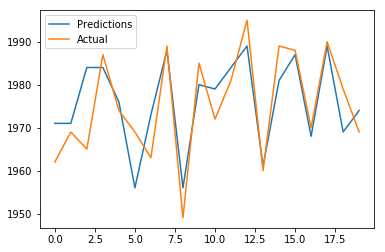

In [116]:
print("Accuracy: ", accuracy_score(Birth_y_test, predictions))
print(classification_report(Birth_y_test, predictions))
print(confusion_matrix(Birth_y_test, predictions))

res = pd.DataFrame( data = {'Predictions': predictions, 'Actual': Birth_y_test} )
res[:20].plot()

labels = list(set(Birth_y_test))

confusion_matrix_heatmap(confusion_matrix(Birth_y_test,predictions))

math.sqrt(mean_squared_error(predictions,Birth_y_test))


# Predicting Gender

In [122]:

clf = RandomForestClassifier()


AdaBoostClf = AdaBoostClassifier(clf, n_estimators=2, random_state=0)

GenderPipeline = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', AdaBoostClf),
])

print('Fitting Clf')
GenderPipeline.fit(Gender_X_train, Gender_y_train)
print('Getting Predictions')
predictions = GenderPipeline.predict(Gender_X_test)

Fitting Clf


/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jay/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Getting Predictions


# Evaluating Gender Classifier

In [132]:
print("Accuracy: ", accuracy_score(Gender_y_test, predictions))
print(classification_report(Gender_y_test, predictions))
print(confusion_matrix(Gender_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(Gender_y_test, predictions))

print(predictions[30:40])
print(Birth_y_test[30:40])

res = pd.DataFrame( data = {'Predictions': predictions, 'Actual': Gender_y_test} )
res[:100].plot()

math.sqrt(mean_squared_error(predictions,Gender_y_test))

Accuracy:  0.7837837837837838
              precision    recall  f1-score   support

      female       0.77      0.77      0.77       283
        male       0.79      0.79      0.79       309

   micro avg       0.78      0.78      0.78       592
   macro avg       0.78      0.78      0.78       592
weighted avg       0.78      0.78      0.78       592

[[219  64]
 [ 64 245]]


TypeError: confusion_matrix_heatmap() missing 1 required positional argument: 'index'

# Inferrering Birth Year from Gender and Text

Pipeline(memory=None,
     steps=[('processor', DocumentProcessor(process_method=<function get_tokens_fql at 0x7f2a7bc7dae8>)), ('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClas...ose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=2, random_state=0))])

# Evaluating Birth Year from Gender Classifier

In [131]:
#Testing
#path = 'alishapatel28_tweets.json'
path = 'ashnapatel_tweets.json'
    
def getTestData():
    # Read in the twitter text
    data = []
    with open(path) as json_file:  
        data = json.load(json_file)

    return data

def getTestDocument(data):
    try:
        doc = Document({}) #include metadata
        for tweet in data:
            doc.extract_features_from_text(tweet['full_text'])
            #print(tweet['full_text'])
        return doc
    except:
        print("An exception occurred")

TestCorpus = getTestData()

TestCorpus = getTestDocument(TestCorpus)
      
PredictedBirthYear = BirthYearPipeline.predict([TestCorpus])
PredictedGender = GenderPipeline.predict([TestCorpus])     
print('Predicted Birth-Year for: ', path, 'is: ', PredictedBirthYear)
print('Predicted Age for ', path, 'is: ', 2019 - PredictedBirthYear )
print('Predicted Gender for: ', path, 'is: ', PredictedGender)


    

Predicted Birth-Year for:  ashnapatel_tweets.json is:  [1986.]
Predicted Age for  ashnapatel_tweets.json is:  [33.]
Predicted Gender for:  ashnapatel_tweets.json is:  ['female']


[1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1995.0]